In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('/home/asavari/Downloads/Clustering_Data.csv')

In [3]:
data

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


In [4]:
# Extract features (drop Customer_Segment if it exists since we want to cluster without using labels)
if 'Customer_Segment' in data.columns:
    features = data.drop(columns=['Customer_Segment'])
else:
    features = data

X = features.values

In [5]:
# Normalization
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X = (X - X_min) / (X_max - X_min)*10 + 1

In [6]:
# Function to initialize centroids
def initialize_centroids(X, k):
    np.random.seed(42)  # For reproducibility
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

In [7]:
# Function to assign points to the nearest centroid
def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

In [8]:
# Function to update centroids
def update_centroids(X, labels, k):
    new_centroids = []
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids.append(cluster_points.mean(axis=0))
        else:
            new_centroids.append(np.random.uniform(X.min(axis=0), X.max(axis=0)))
    return np.array(new_centroids)

In [9]:
# K-means algorithm
def k_means(X, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return centroids, labels

In [10]:
# Finding the optimal number of clusters using the Elbow Method
def find_optimal_clusters(X, max_k=10):
    inertias = []
    for k in range(1, max_k + 1):
        centroids, labels = k_means(X, k)
        inertia = sum(np.linalg.norm(X[labels == i] - centroids[i], axis=1).sum() for i in range(k))
        inertias.append(inertia)
    return inertias

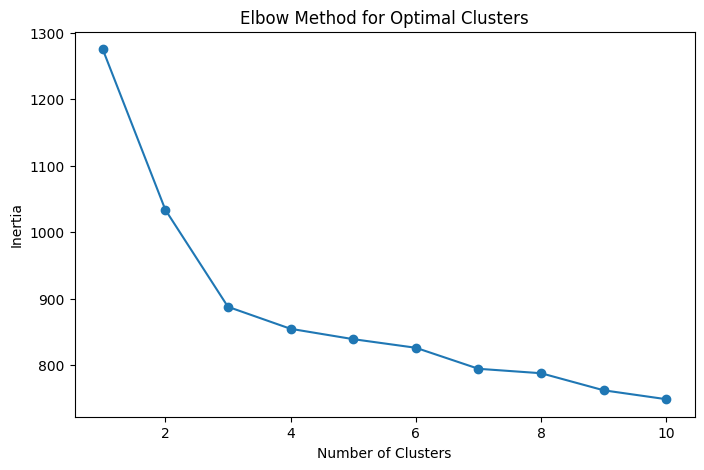

In [11]:
# Plot the Elbow Method
inertias = find_optimal_clusters(X, max_k=10)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [12]:
# Based on the Elbow Method, choose an optimal number of clusters (e.g., k=3)
k = 3  # Adjust based on the elbow plot
centroids, labels = k_means(X, k)

# Print the cluster centers
print("Cluster Centers:")
print(pd.DataFrame(centroids, columns=features.columns))

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

Cluster Centers:
    Alcohol  Malic_Acid       Ash  Ash_Alcanity  Magnesium  Total_Phenols  \
0  4.156642    3.433026  5.733045      5.976272   3.494824       5.549535   
1  8.077193    3.418972  6.863636      4.442440   5.115942       7.432759   
2  6.446890    5.784405  6.601361      6.383318   4.114625       3.447649   

   Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  Color_Intensity  \
0    4.839997              5.109015         4.973762         2.495612   
1    6.558720              3.993711         5.786540         4.568828   
2    2.071346              7.185249         3.282765         5.826404   

        Hue     OD280   Proline  
0  5.703833  6.896854  2.584698  
1  5.811653  7.913309  6.990133  
2  2.925499  2.609058  3.473998  


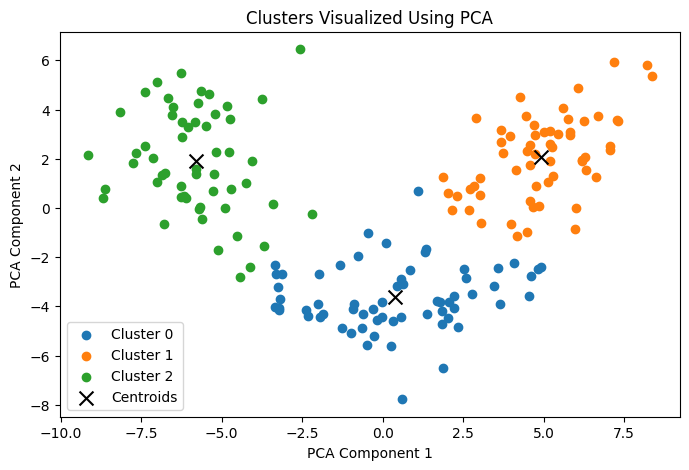

In [13]:
plt.figure(figsize=(8, 5))
for i in range(k):
    cluster_points = X_pca[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
plt.scatter(pca.transform(centroids)[:, 0], pca.transform(centroids)[:, 1], color='black', marker='x', s=100, label='Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters Visualized Using PCA')
plt.legend()
plt.show()